# Анализ данных NGS. Домашнее задание № 2

Выполнил: Олег Вавулов

In [125]:
import os
import sys
sys.path.insert(0, os.getcwd())
import functions as f
import subprocess as sbp
import re
import vcf
# import gzip
# import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
# from numba import njit
from matplotlib import pyplot as plt
# import seaborn as sns
from itertools import product
from Bio.Seq import Seq
from copy import copy

import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

Данные храним вне проекта

In [2]:
cwd = os.getcwd()
data_path = os.path.join(f.get_prev_path(cwd, 2), "data", "hw_2")
bin_path = os.path.join(f.get_prev_path(cwd, 2), "bin")

# Часть 1: анализ ридов Illumina

## E.coli/100x

In [3]:
ecoli_genome = "MG1655-K12.fasta"

Результаты

In [4]:
res_path = os.path.join(cwd, "ecoli100x_results")
if not os.path.exists(res_path): os.mkdir(res_path)

#### 0. Разбораться с Bowtie2 / bwa mem

In [316]:
print(f"""bwa index {os.path.join(data_path, "E.coli", ecoli_genome)}""")

bwa index /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta


In [317]:
!bwa index /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta

[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.12 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.02 sec
[bwa_index] Construct SA from BWT and Occ... 0.31 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta
[main] Real time: 1.548 sec; CPU: 1.544 sec


Выполним выравнивание

In [318]:
print(f"""bwa mem  {os.path.join(data_path, "E.coli", ecoli_genome)} \
{os.path.join(data_path, "E.coli", "100x.1.fastq.gz")} {os.path.join(data_path, "E.coli", "100x.2.fastq.gz")} \
> {os.path.join(cwd, "ecoli100x_results", "alignment.sam")}""")

bwa mem  /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/100x.1.fastq.gz /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/100x.2.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli100x_results/alignment.sam


In [319]:
!bwa mem  /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/100x.1.fastq.gz /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/100x.2.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli100x_results/alignment.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 100000 sequences (10000000 bp)...
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 48198, 0, 1)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (207, 214, 222)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (177, 252)
[M::mem_pestat] mean and std.dev: (214.45, 10.19)
[M::mem_pestat] low and high boundaries for proper pairs: (162, 267)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 100000 reads in 3.441 CPU sec, 3.298 real sec
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 48239, 0, 0)
[M::mem_pestat] skip orientat

In [320]:
!samtools view -S -b ./ecoli100x_results/alignment.sam > ./ecoli100x_results/alignment.bam

In [322]:
!samtools flagstat ./ecoli100x_results/alignment.bam

5000581 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
581 + 0 supplementary
0 + 0 duplicates
4991553 + 0 mapped (99.82% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4978334 + 0 properly paired (99.57% : N/A)
4983734 + 0 with itself and mate mapped
7238 + 0 singletons (0.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


99.82 % процентов ридов приложились. Отсортируем результат

In [323]:
!samtools sort ./ecoli100x_results/alignment.bam -o ./ecoli100x_results/alignment_sorted.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...


#### 1. Покрытие генома.

In [324]:
!samtools coverage ./ecoli100x_results/alignment_sorted.bam -m

gi|49175990|ref|NC_000913.2| (4.64Mbp)
>  90.00% │████████████████████████████████████████│ Number of reads: 4991553
>  80.00% │████████████████████████████████████████│     (7238 filtered)
>  70.00% │████████████████████████████████████████│ Covered bases:   4.64Mbp
>  60.00% │████████████████████████████████████████│ Percent covered: 100%
>  50.00% │████████████████████████████████████████│ Mean coverage:   105x
>  40.00% │████████████████████████████████████████│ Mean baseQ:      33.4
>  30.00% │████████████████████████████████████████│ Mean mapQ:       58.9
>  20.00% │████████████████████████████████████████│ 
>  10.00% │████████████████████████████████████████│ Histo bin width: 116.0Kbp
>   0.00% │████████████████████████████████████████│ Histo max bin:   100%
          1       1.16M     2.32M     3.48M      4.64M  


In [325]:
!bedtools genomecov -ibam ./ecoli100x_results/alignment_sorted.bam -d > ./ecoli100x_results/detailed_coverage_hist.tsv

In [162]:
coverage_report = pd.read_csv("./ecoli100x_results/detailed_coverage_hist.tsv", sep="\t", header=None)
coverage_report.head()

,0,1,2
0,gi|49175990|ref|NC_000913.2|,1,84
1,gi|49175990|ref|NC_000913.2|,2,89
2,gi|49175990|ref|NC_000913.2|,3,92
3,gi|49175990|ref|NC_000913.2|,4,94
4,gi|49175990|ref|NC_000913.2|,5,96


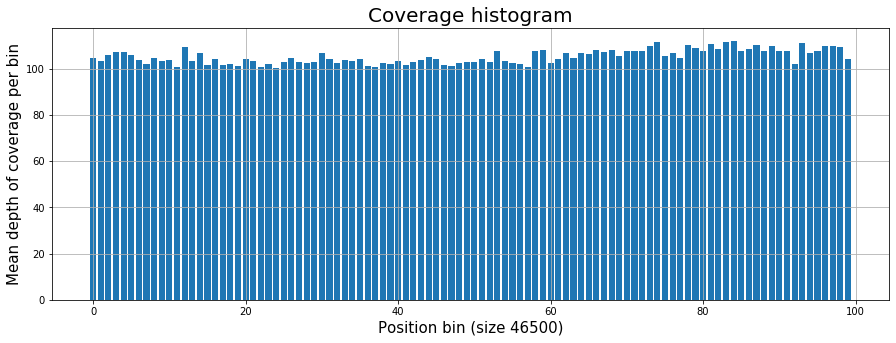

In [328]:
BIN_SIZE = 46500

coverage_report["bins"] = coverage_report[1].apply(lambda x: x // BIN_SIZE)
hist = coverage_report.groupby("bins")[2].mean()

plt.figure(figsize=(15, 5))
plt.grid()
plt.title("Coverage histogram", fontsize=20)
plt.ylabel("Mean depth of coverage per bin", fontsize=15)
plt.xlabel(f"Position bin (size {BIN_SIZE})", fontsize=15)
plt.bar(hist.index, hist.values);

#### 2. Распределение расстояния вставки.

По битовому флагу выберем только правильно выравненные пары, причем из них выберем только первый рид, чтобы не задубливать значения. Соответствующее значение флага: 67.

Также нужно отбросить химерные выравнивания. Добавляем флаг 2048

In [349]:
!samtools view -f 67 -F 2048 ./ecoli100x_results/alignment_sorted.bam | awk '{print $9}' > ./ecoli100x_results/insert_size_values.txt

In [7]:
insert_size_data = pd.read_csv("./results/ecoli100x_results/insert_size_values.txt", header=None).values.reshape(1, -1)[0]
insert_size_data = pd.Series(insert_size_data).abs() # риды выравнявшиеся на минус нить имеют отрицательное значение вставки

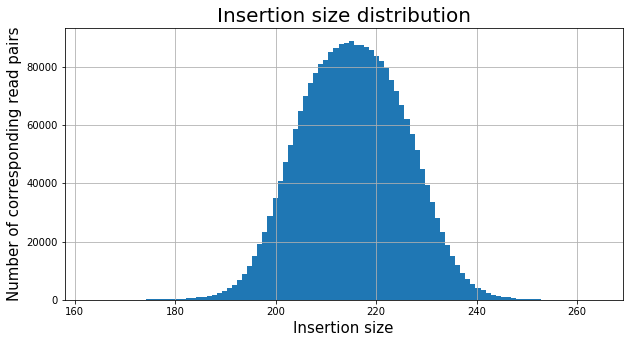

In [13]:
plt.title("Insertion size distribution", fontsize=20)
plt.xlabel("Insertion size", fontsize=15)
plt.ylabel("Number of corresponding read pairs", fontsize=15)
insert_size_data.abs().hist(bins=100, figsize=(10, 5));

In [353]:
print(f"Insertion size statistics\nMean:\t\t{insert_size_data.mean():.2f}\nStd:\t\t{insert_size_data.std():.2f}\n95% confband:\t{insert_size_data.quantile(0.025), insert_size_data.quantile(0.975)}")

Insertion size statistics
Mean:		215.38
Std:		10.22
95% confband:	(196.0, 235.0)


#### 3. Частоты различных замен

In [354]:
!samtools index ./ecoli100x_results/alignment_sorted.bam

In [177]:
MAX_DEPTH = 120

In [178]:
print(f"""bcftools mpileup --threads 12 -d {MAX_DEPTH} \
-f {os.path.join(data_path, "E.coli", ecoli_genome)} \
{os.path.join(res_path, "alignment_sorted.bam")} -o {os.path.join(res_path, "variants.vcf")}""")

bcftools mpileup --threads 12 -d 120 -f /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/alignment_sorted.bam -o /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/variants.vcf


In [159]:
%%time
!bcftools mpileup --threads 12 -d 120 -f /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/alignment_sorted.bam -o /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/variants.vcf

[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
CPU times: user 2.14 s, sys: 600 ms, total: 2.74 s
Wall time: 3min 33s


In [160]:
!bcftools stats ./ecoli100x_results/variants.vcf > ./ecoli100x_results/stats.txt

In [161]:
with open(os.path.join(res_path, "stats.txt")) as f:
    subs_stat = pd.DataFrame([s.split("\t")[2:] for s in f.readlines() if s.startswith("ST")], columns=["subst", "quantity"])
    subs_stat.quantity = subs_stat.quantity.astype(int)
    subs_stat.subst = subs_stat.subst.apply(lambda x: x.split(">"))
    subs_stat.insert(loc=0, column="ref", value=subs_stat.subst.apply(lambda x: x.pop(0)))
    subs_stat.insert(loc=0, column="read", value=subs_stat.subst.apply(lambda x: x.pop(0)))
    subs_stat.drop("subst", axis=1, inplace=True)

substitution_matrix = pd.DataFrame(np.zeros((4, 4)), index=list("ACGT"), columns=list("ACGT")).astype(int)
for sub in subs_stat.values:
    read, ref, q = sub
    substitution_matrix.loc[read, ref] = q
substitution_matrix

,A,C,G,T
A,0,38337,27167,14196
C,118972,0,27029,50732
G,50490,26657,0,118906
T,14332,27219,38284,0


In [163]:
sum_read_bases = coverage_report[2].sum()
print(f"Total bases in reads:\t{sum_read_bases}")
sum_var_bases = substitution_matrix.sum().sum()
print(f"Bases with variants:\t{sum_var_bases}")
print(f"Mean error rate:\t{sum_var_bases/sum_read_bases:.9f}")

Total bases in reads:	488236407
Bases with variants:	552321
Mean error rate:	0.001131257


# Повторный расчет матрицы замен

In [107]:
import pysam
import gzip
import pyfastx as fx

In [100]:
def analyse_mapping(mapping):
#     if not mapping.is_primary:
#         return
    read = mapping.seq
    r = reference[mapping.reference_start: mapping.reference_end]
    q = read[mapping.qstart: mapping.qend]
    r_idx = 0
    q_idx = 0
    for sort, n in mapping.cigar:
        if sort == 0:
#             print(r_idx, q_idx)
#             print(r[r_idx:], q[q_idx:])
            for _ in range(n):
                r_nt = r[r_idx]
                q_nt = q[q_idx]
                if r_nt != q_nt:
                    substitution_matrix.loc["r_"+r_nt, "q_"+q_nt] += 1
                r_idx += 1
                q_idx += 1
        elif sort == 1:
            for _ in range(n):
                q_nt = q[q_idx]
                substitution_matrix.loc["r_gap", "q_"+q_nt] += 1
                q_idx += 1
        elif sort == 2:
            for _ in range(n):
                r_nt = r[r_idx]
                substitution_matrix.loc["r_"+r_nt, "q_gap"] += 1
                r_idx += 1
        elif sort == 4 or sort == 5:
            pass
        else:
            print(sort)
            raise Exception

In [108]:
sam = pysam.AlignmentFile("./results/ecoli100x_results/alignment_sorted.bam").fetch()

In [109]:
substitution_matrix = pd.DataFrame(
    index=["r_"+x for x in ["gap"]+list("ACGTN")],
    columns=["q_"+x for x in ["gap"]+list("ACGTN")], data=0)

In [113]:
# substitution_matrix

In [111]:
with open(os.path.join(data_path, "E.coli", ecoli_genome)) as f:
    reference = f.read()
reference = "".join(reference.split("\n")[1:])

In [112]:
for mapp in tqdm(sam):
    analyse_mapping(mapp)

4998791it [15:04, 5529.19it/s] 


In [126]:
sub1 = deepcopy(substitution_matrix)
sub1

,q_gap,q_A,q_C,q_G,q_T,q_N
r_gap,0,1668,3238,3401,1668,37
r_A,1460,0,637340,380536,145879,84469
r_C,1188,272766,0,240021,157971,84271
r_G,1272,159165,241260,0,273569,84532
r_T,1338,146392,379576,637018,0,84100
r_N,0,0,0,0,0,0


In [129]:
print(f"Total error rate: {100*sub1.values.sum()/488236407:.2f}%")

Total error rate: 0.82%


## E.coli/ecoli_mda_lane1

Результаты

In [164]:
res_path = os.path.join(cwd, "ecoli_mda_results")
if not os.path.exists(res_path): os.mkdir(res_path)

#### 0. Разбораться с Bowtie2 / bwa mem

Выполним выравнивание

In [414]:
print(f"""bwa mem  {os.path.join(data_path, "E.coli", ecoli_genome)} \
{os.path.join(data_path, "E.coli", "ecoli_mda_lane1_left.downsampled.fastq.gz")} \
{os.path.join(data_path, "E.coli", "ecoli_mda_lane1_right.downsampled.fastq.gz")} \
> {os.path.join(res_path, "alignment.sam")}""")

bwa mem  /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/ecoli_mda_lane1_left.downsampled.fastq.gz /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/ecoli_mda_lane1_right.downsampled.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/alignment.sam


In [412]:
bwa mem  /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/ecoli_mda_lane1_left.downsampled.fastq.gz /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/ecoli_mda_lane1_right.downsampled.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/alignment.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 100000 sequences (10000000 bp)...
[M::process] read 100000 sequences (10000000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (112, 44880, 44, 139)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (890, 2400, 4678)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 12254)
[M::mem_pestat] mean and std.dev: (3073.67, 2476.43)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 16042)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (249, 279, 299)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (149, 399)
[M::mem_pestat] mean and std.dev: (277.18, 39.54)
[M::mem_pestat] low and high boundaries for proper pairs: (99, 449)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50

In [415]:
!samtools view -S -b ./ecoli_mda_results/alignment.sam > ./ecoli_mda_results/alignment.bam

In [416]:
!samtools flagstat ./ecoli_mda_results/alignment.bam

5869326 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
40560 + 0 supplementary
0 + 0 duplicates
5706946 + 0 mapped (97.23% : N/A)
5828766 + 0 paired in sequencing
2914383 + 0 read1
2914383 + 0 read2
5151500 + 0 properly paired (88.38% : N/A)
5647486 + 0 with itself and mate mapped
18900 + 0 singletons (0.32% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


97.23 % процентов ридов приложились. Отсортируем результат

In [420]:
!samtools sort ./ecoli_mda_results/alignment.bam -o ./ecoli_mda_results/alignment_sorted.bam

[bam_sort_core] merging from 2 files and 1 in-memory blocks...


#### 1. Покрытие генома.

In [421]:
!samtools coverage ./ecoli_mda_results/alignment_sorted.bam -m

gi|49175990|ref|NC_000913.2| (4.64Mbp)
>  90.00% │█▇██████████  ▃  ████████████████▂▇████▇│ Number of reads: 5706946
>  80.00% │████████████▅▆█ ▇███████████████████████│     (18900 filtered)
>  70.00% │███████████████ ████████████████████████│ Covered bases:   4.48Mbp
>  60.00% │███████████████ ████████████████████████│ Percent covered: 96.54%
>  50.00% │███████████████ ████████████████████████│ Mean coverage:   119x
>  40.00% │███████████████ ████████████████████████│ Mean baseQ:      56.8
>  30.00% │███████████████ ████████████████████████│ Mean mapQ:       58.2
>  20.00% │███████████████ ████████████████████████│ 
>  10.00% │███████████████▅████████████████████████│ Histo bin width: 116.0Kbp
>   0.00% │████████████████████████████████████████│ Histo max bin:   100%
          1       1.16M     2.32M     3.48M      4.64M  


In [422]:
!bedtools genomecov -ibam ./ecoli_mda_results/alignment_sorted.bam -d > ./ecoli_mda_results/detailed_coverage_hist.tsv

In [172]:
coverage_report = pd.read_csv("./ecoli_mda_results/detailed_coverage_hist.tsv", sep="\t", header=None)
coverage_report.head()

,0,1,2
0,gi|49175990|ref|NC_000913.2|,1,16
1,gi|49175990|ref|NC_000913.2|,2,17
2,gi|49175990|ref|NC_000913.2|,3,20
3,gi|49175990|ref|NC_000913.2|,4,20
4,gi|49175990|ref|NC_000913.2|,5,20


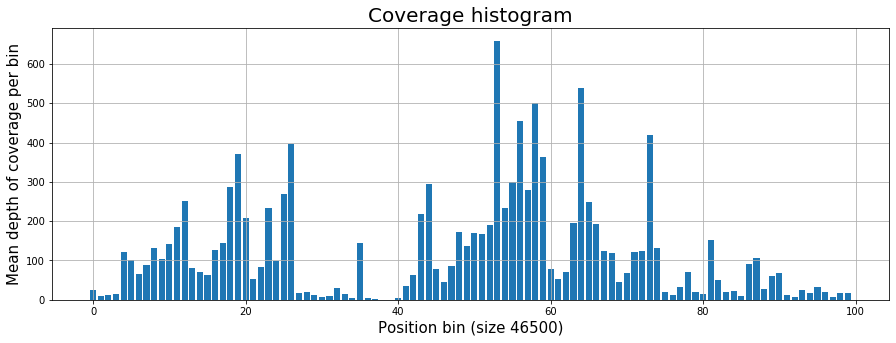

In [424]:
BIN_SIZE = 46500

coverage_report["bins"] = coverage_report[1].apply(lambda x: x // BIN_SIZE)
hist = coverage_report.groupby("bins")[2].mean()

plt.figure(figsize=(15, 5))
plt.grid()
plt.title("Coverage histogram", fontsize=20)
plt.ylabel("Mean depth of coverage per bin", fontsize=15)
plt.xlabel(f"Position bin (size {BIN_SIZE})", fontsize=15)
plt.bar(hist.index, hist.values);

#### 2. Распределение расстояния вставки.

По битовому флагу выберем только правильно выравненные пары, причем из них выберем только первый рид, чтобы не задубливать значения. Соответствующее значение флага: 67.

Также нужно отбросить химерные выравнивания. Добавляем флаг 2048

In [425]:
!samtools view -f 67 -F 2048 ./ecoli_mda_results/alignment_sorted.bam | awk '{print $9}' > ./ecoli_mda_results/insert_size_values.txt

In [426]:
insert_size_data = pd.read_csv("./ecoli_mda_results/insert_size_values.txt", header=None).values.reshape(1, -1)[0]
insert_size_data = pd.Series(insert_size_data).abs() # риды выравнявшиеся на минус нить имеют отрицательное значение вставки

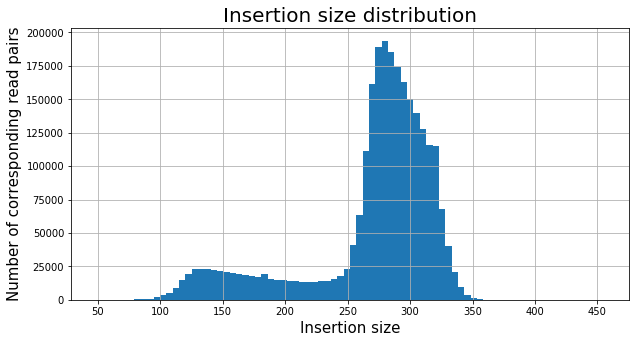

In [427]:
plt.title("Insertion size distribution", fontsize=20)
plt.xlabel("Insertion size", fontsize=15)
plt.ylabel("Number of corresponding read pairs", fontsize=15)
insert_size_data.abs().hist(bins=80, figsize=(10, 5));

In [428]:
print(f"Insertion size statistics\nMean:\t\t{insert_size_data.mean():.2f}\nStd:\t\t{insert_size_data.std():.2f}\n95% confband:\t{insert_size_data.quantile(0.025), insert_size_data.quantile(0.975)}")

Insertion size statistics
Mean:		269.46
Std:		52.65
95% confband:	(127.0, 330.0)


#### 3. Частоты различных замен

In [429]:
!samtools index ./ecoli_mda_results/alignment_sorted.bam

In [167]:
MAX_DEPTH = 800

In [170]:
print(f"""bcftools mpileup --threads 12 -d {MAX_DEPTH} \
-f {os.path.join(data_path, "E.coli", ecoli_genome)} \
{os.path.join(res_path, "alignment_sorted.bam")} -o {os.path.join(res_path, "variants.vcf")}""")

bcftools mpileup --threads 12 -d 800 -f /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/alignment_sorted.bam -o /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/variants.vcf


In [171]:
%%time
!bcftools mpileup --threads 12 -d 800 -f /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/E.coli/MG1655-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/alignment_sorted.bam -o /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/ecoli_mda_results/variants.vcf

[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 800
CPU times: user 2.31 s, sys: 650 ms, total: 2.96 s
Wall time: 3min 51s


In [173]:
!bcftools stats ./ecoli_mda_results/variants.vcf > ./ecoli_mda_results/stats.txt

In [174]:
with open(os.path.join(res_path, "stats.txt")) as f:
    subs_stat = pd.DataFrame([s.split("\t")[2:] for s in f.readlines() if s.startswith("ST")], columns=["subst", "quantity"])
    subs_stat.quantity = subs_stat.quantity.astype(int)
    subs_stat.subst = subs_stat.subst.apply(lambda x: x.split(">"))
    subs_stat.insert(loc=0, column="ref", value=subs_stat.subst.apply(lambda x: x.pop(0)))
    subs_stat.insert(loc=0, column="read", value=subs_stat.subst.apply(lambda x: x.pop(0)))
    subs_stat.drop("subst", axis=1, inplace=True)

substitution_matrix = pd.DataFrame(np.zeros((4, 4)), index=list("ACGT"), columns=list("ACGT")).astype(int)
for sub in subs_stat.values:
    read, ref, q = sub
    substitution_matrix.loc[read, ref] = q
substitution_matrix

,A,C,G,T
A,0,162735,110178,105540
C,272701,0,133314,197716
G,196456,132781,0,269479
T,104890,110967,160857,0


In [175]:
sum_read_bases = coverage_report[2].sum()
print(f"Total bases in reads:\t{sum_read_bases}")
sum_var_bases = substitution_matrix.sum().sum()
print(f"Bases with variants:\t{sum_var_bases}")
print(f"Mean error rate:\t{sum_var_bases/sum_read_bases:.9f}")

Total bases in reads:	553862082
Bases with variants:	1957614
Mean error rate:	0.003534479


# Повторный расчет матрицы замен

In [130]:
sam = pysam.AlignmentFile("./results/ecoli_mda_results/alignment_sorted.bam").fetch()

In [132]:
substitution_matrix = pd.DataFrame(
    index=["r_"+x for x in ["gap"]+list("ACGTN")],
    columns=["q_"+x for x in ["gap"]+list("ACGTN")], data=0)

In [133]:
with open(os.path.join(data_path, "E.coli", ecoli_genome)) as f:
    reference = f.read()
reference = "".join(reference.split("\n")[1:])

In [134]:
for mapp in tqdm(sam):
    analyse_mapping(mapp)

5725846it [17:32, 5439.65it/s] 


In [136]:
sub2 = deepcopy(substitution_matrix)
sub2

,q_gap,q_A,q_C,q_G,q_T,q_N
r_gap,0,2519,3659,2993,2575,132
r_A,2252,0,616006,377466,168711,204490
r_C,1807,282365,0,219045,175047,198160
r_G,1773,175310,223157,0,277789,196474
r_T,2226,170488,381076,604303,0,202196
r_N,0,0,0,0,0,0


In [137]:
print(f"Total error rate: {100*sub2.values.sum()/553862082:.2f}%")

Total error rate: 0.81%


# Часть 2: анализ ридов IonTorrent

In [138]:
it_genome = "DH10B-K12.fasta"

Результаты

In [4]:
res_path = os.path.join(cwd, "it_results")
if not os.path.exists(res_path): os.mkdir(res_path)

#### Выравнивание

In [505]:
print(f"""bwa index {os.path.join(data_path, "2b", it_genome)}""")

bwa index /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta


In [506]:
!bwa index /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta

[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.15 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.03 sec
[bwa_index] Construct SA from BWT and Occ... 0.32 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta
[main] Real time: 1.584 sec; CPU: 1.578 sec


Выполним выравнивание

In [508]:
print(f"""bwa mem {os.path.join(data_path, "2b", it_genome)} \
{os.path.join(data_path, "2b", "B22-730.fastq.gz")} > {os.path.join(res_path, "alignment.sam")}""")

bwa mem /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/B22-730.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/alignment.sam


In [509]:
!bwa mem /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/B22-730.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/alignment.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 30580 sequences (10000589 bp)...
[M::process] read 30700 sequences (10000499 bp)...
[M::mem_process_seqs] Processed 30580 reads in 4.186 CPU sec, 4.091 real sec
[M::process] read 30654 sequences (10000464 bp)...
[M::mem_process_seqs] Processed 30700 reads in 4.608 CPU sec, 4.479 real sec
[M::process] read 30558 sequences (10000069 bp)...
[M::mem_process_seqs] Processed 30654 reads in 5.309 CPU sec, 5.173 real sec
[M::process] read 30468 sequences (10000148 bp)...
[M::mem_process_seqs] Processed 30558 reads in 3.806 CPU sec, 3.673 real sec
[M::process] read 30596 sequences (10000413 bp)...
[M::mem_process_seqs] Processed 30468 reads in 3.771 CPU sec, 3.627 real sec
[M::process] read 30514 sequences (10000381 bp)...
[M::mem_process_seqs] Processed 30596 reads in 4.215 CPU sec, 4.081 real sec
[M::process] read 30520 sequences (10000266 bp)...
[M::mem_process_seqs] Processed 30514 reads in 3.902 CPU sec, 3.755 real sec
[M::pr

In [510]:
print(f"""bwa mem {os.path.join(data_path, "2b", it_genome)} \
{os.path.join(data_path, "2b", "C24-698.fastq.gz")} > {os.path.join(res_path, "alignment_2.sam")}""")

bwa mem /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/C24-698.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/alignment_2.sam


In [511]:
!bwa mem /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/C24-698.fastq.gz > /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/alignment_2.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 40748 sequences (10000257 bp)...
[M::process] read 40830 sequences (10000256 bp)...
[M::mem_process_seqs] Processed 40748 reads in 2.948 CPU sec, 2.847 real sec
[M::process] read 40678 sequences (10000475 bp)...
[M::mem_process_seqs] Processed 40830 reads in 3.194 CPU sec, 3.041 real sec
[M::process] read 40934 sequences (10000123 bp)...
[M::mem_process_seqs] Processed 40678 reads in 3.751 CPU sec, 3.602 real sec
[M::process] read 40668 sequences (10000353 bp)...
[M::mem_process_seqs] Processed 40934 reads in 2.611 CPU sec, 2.464 real sec
[M::process] read 40714 sequences (10000220 bp)...
[M::mem_process_seqs] Processed 40668 reads in 2.670 CPU sec, 2.497 real sec
[M::process] read 40714 sequences (10000207 bp)...
[M::mem_process_seqs] Processed 40714 reads in 2.847 CPU sec, 2.703 real sec
[M::process] read 40584 sequences (10000468 bp)...
[M::mem_process_seqs] Processed 40714 reads in 2.672 CPU sec, 2.517 real sec
[M::pr

In [512]:
!samtools view -b -o ./it_results/alignment_1.bam ./it_results/alignment.sam
!samtools view -b -o ./it_results/alignment_2.bam ./it_results/alignment_2.sam

In [513]:
!samtools sort ./it_results/alignment_1.bam -o ./it_results/alignment_sorted_1.bam
!samtools sort ./it_results/alignment_2.bam -o ./it_results/alignment_sorted_2.bam

In [514]:
!samtools merge ./it_results/alignment_sorted.bam ./it_results/alignment_sorted_1.bam ./it_results/alignment_sorted_2.bam

Посмотрим статистику

In [515]:
!samtools flagstat ./it_results/alignment_sorted.bam

1184051 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
3724 + 0 supplementary
0 + 0 duplicates
1172097 + 0 mapped (98.99% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


98.99 % процентов ридов приложились. Отсортируем результат

In [516]:
!samtools sort ./it_results/alignment_sorted.bam -o ./it_results/alignment_sorted.bam

#### Анализ покрытия

In [517]:
!samtools coverage ./it_results/alignment_sorted.bam -m

gi|170079663|ref|NC_010473.1| (4.69Mbp)
>  90.00% │████████████████████████████████████████│ Number of reads: 1172097
>  80.00% │████████████████████████████████████████│ 
>  70.00% │████████████████████████████████████████│ Covered bases:   4.69Mbp
>  60.00% │████████████████████████████████████████│ Percent covered: 100%
>  50.00% │████████████████████████████████████████│ Mean coverage:   69.6x
>  40.00% │████████████████████████████████████████│ Mean baseQ:      29.1
>  30.00% │████████████████████████████████████████│ Mean mapQ:       55.9
>  20.00% │████████████████████████████████████████│ 
>  10.00% │████████████████████████████████████████│ Histo bin width: 117.2Kbp
>   0.00% │████████████████████████████████████████│ Histo max bin:   100%
          1       1.17M     2.34M     3.51M      4.69M  


In [518]:
!bedtools genomecov -ibam ./it_results/alignment_sorted.bam -d > ./it_results/detailed_coverage_hist.tsv

In [5]:
coverage_report = pd.read_csv(os.path.join(res_path, "detailed_coverage_hist.tsv"), sep="\t", header=None)
coverage_report.head()

,0,1,2
0,gi|170079663|ref|NC_010473.1|,1,66
1,gi|170079663|ref|NC_010473.1|,2,66
2,gi|170079663|ref|NC_010473.1|,3,67
3,gi|170079663|ref|NC_010473.1|,4,68
4,gi|170079663|ref|NC_010473.1|,5,68


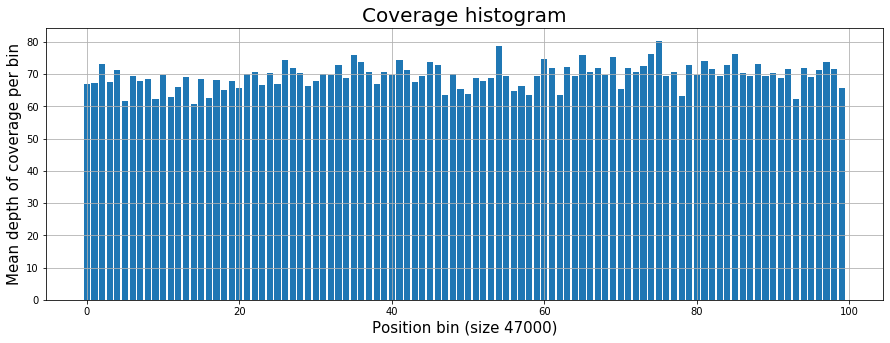

In [182]:
BIN_SIZE = 47000

coverage_report["bins"] = coverage_report[1].apply(lambda x: x // BIN_SIZE)
hist = coverage_report.groupby("bins")[2].mean()

plt.figure(figsize=(15, 5))
plt.grid()
plt.title("Coverage histogram", fontsize=20)
plt.ylabel("Mean depth of coverage per bin", fontsize=15)
plt.xlabel(f"Position bin (size {BIN_SIZE})", fontsize=15)
plt.bar(hist.index, hist.values);

#### Анализ замен

In [521]:
!samtools index ./it_results/alignment_sorted.bam

In [183]:
MAX_DEPTH = 100

In [184]:
print(f"""bcftools mpileup --threads 12 -d {MAX_DEPTH} \
-f {os.path.join(data_path, "2b", it_genome)} \
{os.path.join(res_path, "alignment_sorted.bam")} -o {os.path.join(res_path, "variants.vcf")}""")

bcftools mpileup --threads 12 -d 100 -f /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/alignment_sorted.bam -o /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/variants.vcf


In [60]:
%%time
!bcftools mpileup --threads 12 -f /Users/a18264698/Desktop/BIOINF/2_semester/NGS/data/hw_2/2b/DH10B-K12.fasta /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/alignment_sorted.bam -o /Users/a18264698/Desktop/BIOINF/2_semester/NGS/BI_NGS21_HW/hw_2/it_results/variants.vcf

[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
CPU times: user 12.2 s, sys: 3.6 s, total: 15.8 s
Wall time: 20min 25s


In [67]:
!bcftools stats ./it_results/variants.vcf > ./it_results/stats.txt

In [68]:
!bcftools plugin indel-stats ./it_results/variants.vcf > ./it_results/indelstats.txt

In [93]:
with open(os.path.join(res_path, "stats.txt")) as f:
    indel_stat = pd.DataFrame([s.split("\t")[2:-2] for s in f.readlines() if s.startswith("IDD")], \
                              columns=["length", "n_sites"]).astype(int)

In [94]:
indel_stat

,length,n_sites
0,-24,1
1,-8,1
2,-7,1
3,-6,5
4,-5,17
5,-4,76
6,-3,667
7,-2,9255
8,-1,170387
9,1,254294


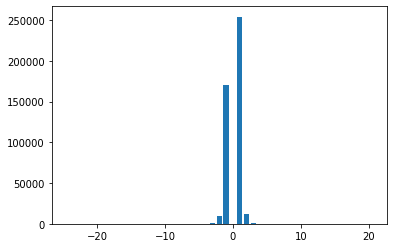

In [102]:
max_indel_size_to_plot = 30
plt.bar(indel_stat[abs(indel_stat.length) < max_indel_size_to_plot].length, \
        indel_stat[abs(indel_stat.length) < max_indel_size_to_plot].n_sites);

In [6]:
with open(os.path.join(res_path, "stats.txt")) as f:
    subs_stat = pd.DataFrame([s.split("\t")[2:] for s in f.readlines() if s.startswith("ST")], columns=["subst", "quantity"])
    subs_stat.quantity = subs_stat.quantity.astype(int)
    subs_stat.subst = subs_stat.subst.apply(lambda x: x.split(">"))
    subs_stat.insert(loc=0, column="ref", value=subs_stat.subst.apply(lambda x: x.pop(0)))
    subs_stat.insert(loc=0, column="read", value=subs_stat.subst.apply(lambda x: x.pop(0)))
    subs_stat.drop("subst", axis=1, inplace=True)

substitution_matrix = pd.DataFrame(np.zeros((4, 4)), index=list("ACGT"), columns=list("ACGT")).astype(int)
for sub in subs_stat.values:
    read, ref, q = sub
    substitution_matrix.loc[read, ref] = q
# substitution_matrix

,A,C,G,T
A,0,6947,20107,7394
C,5986,0,4817,35272
G,35298,4824,0,6049
T,7475,19997,7094,0


In [7]:
sum_read_bases = coverage_report[2].sum()
print(f"Total bases in reads:\t{sum_read_bases}")
sum_var_bases = substitution_matrix.sum().sum()
print(f"Bases with variants:\t{sum_var_bases}")
print(f"Mean error rate:\t{sum_var_bases/sum_read_bases:.9f}")

Total bases in reads:	326185200
Bases with variants:	161260
Mean error rate:	0.000494382


In [108]:
variants = vcf.Reader(filename=os.path.join(res_path, "variants.vcf.gz"))
v = variants.fetch("gi|170079663|ref|NC_010473.1|")

In [67]:
indels = []
for r in tqdm(v):
    if r.is_indel:
        indels.append(r)

5079878it [02:55, 28997.01it/s]


In [104]:
inserts = dict.fromkeys(list("ACGT"), 0)
deletions = dict.fromkeys(list("ACGT"), 0)
for indel in tqdm(indels):
    ref = indel.REF
    alleles = indel.ALT
    for allele in alleles:
        allele = str(allele)
        if ref in allele:
            insert = allele.replace(ref, "")
            for nt in insert:
                inserts[nt] += 1
        else:
            deletion = ref.replace(allele, "")
            for nt in deletion:
                deletions[nt] += 1

100%|██████████| 409387/409387 [00:01<00:00, 370469.50it/s]


In [120]:
substitution_matrix.insert(loc=4, value=0, column="gap")
substitution_matrix = substitution_matrix.T
substitution_matrix.insert(loc=4, value=0, column="gap")
substitution_matrix = substitution_matrix.T

for nt, value in inserts.items():
    substitution_matrix.loc[nt, "gap"] = value
for nt, value in deletions.items():
    substitution_matrix.loc["gap", nt] = value
    
substitution_matrix

,A,C,G,T,gap
A,0,6947,20107,7394,93473
C,5986,0,4817,35272,45706
G,35298,4824,0,6049,45129
T,7475,19997,7094,0,88767
gap,56245,47755,46299,57618,0


# Повторный расчет матрицы замен

In [139]:
sam = pysam.AlignmentFile("./results/it_results/alignment_sorted.bam").fetch()

In [140]:
substitution_matrix = pd.DataFrame(
    index=["r_"+x for x in ["gap"]+list("ACGTN")],
    columns=["q_"+x for x in ["gap"]+list("ACGTN")], data=0)

In [141]:
with open(os.path.join(data_path, "2b", it_genome)) as f:
    reference = f.read()
reference = "".join(reference.split("\n")[1:])

In [142]:
for mapp in tqdm(sam):
    analyse_mapping(mapp)

1172097it [06:23, 3054.14it/s]


In [143]:
sub3 = deepcopy(substitution_matrix)
sub3

,q_gap,q_A,q_C,q_G,q_T,q_N
r_gap,0,263977,126660,125828,265952,0
r_A,156453,0,14271,45595,17661,0
r_C,154611,17111,0,13472,30637,0
r_G,154946,31472,12187,0,17632,0
r_T,157100,17874,46943,14308,0,0
r_N,0,0,0,0,0,0


In [144]:
print(f"Total error rate: {100*sub3.values.sum()/326185200:.2f}%")

Total error rate: 0.52%


Найдем гомополимеры

In [126]:
!awk '/^>/{if (NR==1) {print $0} else if (NR>1) {print "\n"$0}}; !/^>/ {printf toupper($0)}' ../../data/hw_2/2b/DH10B-K12.fasta \
> ./it_results/genome.txt

In [142]:
with open(os.path.join(res_path, "genome.txt"), "r") as f:
    genome = Seq(f.readlines()[1])

In [200]:
HOMOPOLYMER_SIZE = 9
homopolymers = list(map(lambda x: HOMOPOLYMER_SIZE*x, list("ACGT")))

In [203]:
indexes = []
for homopolymer in tqdm(homopolymers[:4]):
    seq = copy(genome)
    while True:
        idx = seq.find(homopolymer)
        if idx != -1:
            indexes.append((indexes[-1] + idx + 1) if indexes else idx)
            seq = seq[idx+1:]
        else:
            break





100%|██████████| 4/4 [00:00<00:00, 131.34it/s]


In [205]:
print(f"""{len(indexes)} homopolymers of size {HOMOPOLYMER_SIZE} have been found""")

22 homopolymers of size 9 have been found


In [207]:
indel_pos_list = []
for indel in indels:
    indel_pos_list.append(indel.POS)

In [211]:
NEAR = 20
near_homopolymer_indels = []
for pos in indel_pos_list:
    for index in indexes:
        if index - NEAR < pos < index + HOMOPOLYMER_SIZE + NEAR:
            near_homopolymer_indels.append(pos)

In [215]:
print(f"""Near homopolymer indel fraction: {len(near_homopolymer_indels)/len(indels)}""")

Near homopolymer indel fraction: 0.00014411791287950032
